In [1]:
import logging

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logging.info("Logging is configured.")

2025-10-08 13:39:02,177 - INFO - Logging is configured.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from doubleml.plm.datasets import make_plr_CCDDHNR2018
import doubleml as dml
from flaml import AutoML
from xgboost import XGBRegressor

# Generate synthetic data
theta = 0.5
data = make_plr_CCDDHNR2018(alpha=theta, n_obs=1000, dim_x=50, return_type="DataFrame", a0=0, a1=1, s1=0.25, s2=0.25)
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,y,d
0,0.487411,1.232045,1.345860,0.669952,-0.235094,-1.072364,-0.166447,2.220082,2.054497,0.547021,...,-0.954895,-0.948912,-1.518998,-2.174335,-2.373005,-0.780121,-0.014858,0.210032,2.847128,2.117386
1,1.479352,-0.110662,-0.295637,0.838477,-0.199330,-1.140087,-0.360072,1.219231,1.498700,0.298433,...,-0.013119,1.340073,1.887896,1.488441,0.287895,0.773279,0.134508,-0.306650,3.013529,1.662156
2,-0.106759,0.064430,-0.134507,-0.276085,-0.207910,0.541444,-0.059223,0.712967,-0.284775,-0.835429,...,-1.168103,-0.770578,-1.279242,-1.938347,-1.520038,-1.180472,-0.900146,-0.148808,1.289840,-0.237988
3,0.334075,-0.370493,-0.746211,-1.239180,-0.445826,-0.551007,0.024858,0.121805,-0.533964,0.233719,...,-2.004662,-2.345362,-1.973343,-1.221955,-0.337721,-0.344705,0.124379,0.271565,1.299271,0.420788
4,-1.655319,-0.784501,-1.155985,0.015009,0.144700,-0.158272,-0.854950,-0.692340,-0.988157,-1.935947,...,-0.622928,-0.311061,0.066714,0.604067,0.122632,1.061310,1.713492,0.467737,-1.303910,-1.648914


In [4]:
fixed_lgbm_params = {
    "subsample_freq": 1,
    "verbose": -1,
    "random_state": 42,
}

In [5]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
def tune_ml_l(fixed_lgbm_params, n_trials=200):

    logging.info("Tuning LGBM outcome model...")
    y = data["y"].values
    x = data.drop(columns=["y", "d"]).values

    def outcome_objective(trial):
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 8, 31),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        }

        model = LGBMRegressor(**(params | fixed_lgbm_params))
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(model, x, y, cv=cv, scoring="neg_root_mean_squared_error").mean()

        return score

    # Run study
    outcome_study = optuna.create_study(direction="maximize")
    outcome_study.optimize(outcome_objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    logging.info("Best outcome RMSE: %s", -1.0 * outcome_study.best_value)
    logging.info("Best outcome params: %s", outcome_study.best_params)

    return outcome_study

In [7]:
ml_l_study = tune_ml_l(fixed_lgbm_params, n_trials=50)

2025-10-08 13:39:06,100 - INFO - Tuning LGBM outcome model...


  0%|          | 0/50 [00:00<?, ?it/s]

2025-10-08 13:44:15,176 - INFO - Best outcome RMSE: 1.1407775256913724
2025-10-08 13:44:15,176 - INFO - Best outcome params: {'learning_rate': 0.0033021471756339163, 'num_leaves': 9, 'max_depth': 2, 'min_child_samples': 41, 'min_split_gain': 0.0076683792024169195, 'colsample_bytree': 0.9944372591613093, 'subsample': 0.7232198565091926, 'reg_alpha': 0.7048313358189802, 'reg_lambda': 0.7807699031430471, 'n_estimators': 1115}


In [8]:
def tune_ml_m(fixed_lgbm_params, n_trials=200):

    logging.info("Tuning LGBM treatment model...")
    y = data["d"].values
    x = data.drop(columns=["y", "d"]).values

    def treatment_objective(trial):
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 8, 31),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        }

        model = LGBMRegressor(**(params | fixed_lgbm_params))
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(model, x, y, cv=cv, scoring="neg_root_mean_squared_error").mean()

        return score

    # Run study
    treatment_study = optuna.create_study(direction="maximize")
    treatment_study.optimize(treatment_objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    logging.info("Best treatment RMSE: %s", -1.0 * treatment_study.best_value)
    logging.info("Best treatment params: %s", treatment_study.best_params)

    return treatment_study

In [9]:
ml_m_study = tune_ml_m(fixed_lgbm_params, n_trials=50)

2025-10-08 13:44:15,250 - INFO - Tuning LGBM treatment model...


  0%|          | 0/50 [00:00<?, ?it/s]

2025-10-08 13:46:26,303 - INFO - Best treatment RMSE: 0.9898729116223637
2025-10-08 13:46:26,304 - INFO - Best treatment params: {'learning_rate': 0.0035769949967398348, 'num_leaves': 29, 'max_depth': 2, 'min_child_samples': 26, 'min_split_gain': 0.004474033975333781, 'colsample_bytree': 0.881146887947653, 'subsample': 0.9004475092675139, 'reg_alpha': 0.2730279493459647, 'reg_lambda': 0.29933765637216847, 'n_estimators': 1719}


In [10]:
dml_data = dml.DoubleMLData(data, y_col="y", d_cols="d")
ml_l = LGBMRegressor(**(ml_l_study.best_params | fixed_lgbm_params))
ml_m = LGBMRegressor(**(ml_m_study.best_params | fixed_lgbm_params))
dml_plr_tuned = dml.DoubleMLPLR(dml_data, ml_l=ml_l, ml_m=ml_m, n_folds=5, n_rep=1)
dml_plr_tuned.fit()
ci_tuned = dml_plr_tuned.confint(level=0.9)
print(dml_plr_tuned.summary)

       coef   std err          t         P>|t|    2.5 %    97.5 %
d  0.485429  0.032791  14.803915  1.381987e-49  0.42116  0.549697


In [11]:
dml_data = dml.DoubleMLData(data, y_col="y", d_cols="d")
dml_plr_default = dml.DoubleMLPLR(dml_data, ml_l=LGBMRegressor(), ml_m=LGBMRegressor(), n_folds=5, n_rep=1)
dml_plr_default.fit()
ci_default = dml_plr_default.confint(level=0.9)
print(dml_plr_default.summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.459987  0.031945  14.399312  5.226110e-47  0.397376  0.522598


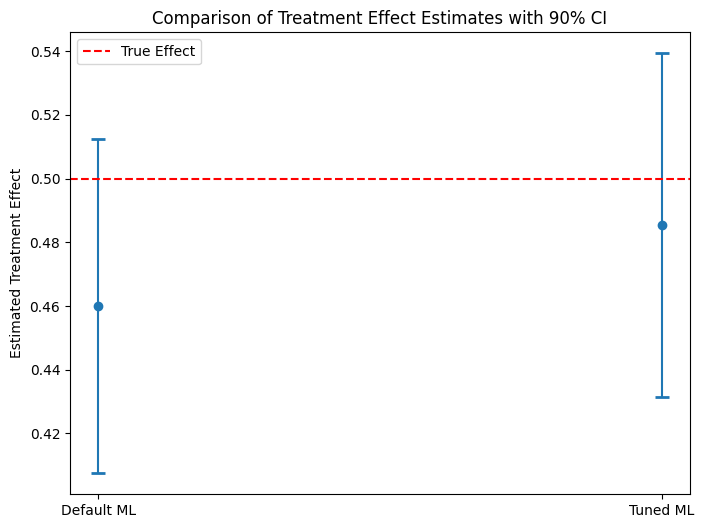

In [12]:
# plot effect and ci for both tuned and default

plt.figure(figsize=(8, 6))
plt.errorbar(x=[0, 1], y=[dml_plr_default.coef[0], dml_plr_tuned.coef[0]],
             yerr=[[dml_plr_default.coef[0] - ci_default.iloc[0,0], dml_plr_tuned.coef[0] - ci_tuned.iloc[0,0]],
                   [ci_default.iloc[0,1] - dml_plr_default.coef[0], ci_tuned.iloc[0,1] - dml_plr_tuned.coef[0]]],
             fmt='o', capsize=5, capthick=2)
plt.xticks([0, 1], ['Default ML', 'Tuned ML'])
plt.ylabel('Estimated Treatment Effect')
plt.title('Comparison of Treatment Effect Estimates with 90% CI')
plt.axhline(y=0.5, color='r', linestyle='--', label='True Effect')
plt.legend()
plt.show()